## Import libraries

In [1]:
import os
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from fastai.vision.all import *

import warnings
warnings.filterwarnings("ignore")

import urllib
import itertools
import seaborn as sns
import random, glob

from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings ('ignore')
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout, SpatialDropout2D, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2

from sklearn.metrics import confusion_matrix

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [2]:
def plot_loss_and_acc(hist):
    plt.figure(1, figsize = (15, 5))
    plt.subplot(1,2,1)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.plot( hist.history["loss"], label = "Training Loss")
    plt.plot( hist.history["val_loss"], label = "Validation Loss")
    plt.grid(True)
    plt.legend()

    plt.subplot(1,2,2)
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.plot( hist.history["accuracy"], label = "Training Accuracy")
    plt.plot( hist.history["val_accuracy"], label = "Validation Accuracy")
    plt.grid(True)
    plt.legend()
    plt.show()

In [3]:
def predict_classes(model, test_data):

    predictions = model.predict(test_data)
    predicted_classes = np.argmax(predictions, axis=1)

    return predicted_classes

In [4]:
def show_confusion_matrix(true_classes, predicted_classes, class_labels):

    conf_matrix = confusion_matrix(true_classes, predicted_classes)
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

In [5]:
def count_metrics(true_classes, predicted_classes):
    accuracy = accuracy_score(true_classes, predicted_classes)
    precision = precision_score(true_classes, predicted_classes, average='macro')
    recall = recall_score(true_classes, predicted_classes, average='macro')
    f1 = f1_score(true_classes, predicted_classes, average='macro')

    return [accuracy, precision, recall, f1]

In [6]:
def plot_cost(train_loss, val_loss):

    epochs = range(1, len(train_loss) + 1)

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

## Data loading and visualization

In [7]:
path = os.path.join('dataset')
labels = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

In [8]:
histogram_labels = []

for label in labels:
    directory = os.path.join(path, label)
    print(f"Class: {label} — {len(os.listdir(directory))} samples")
    histogram_labels.append((label, len(os.listdir(directory))))

Class: cardboard — 403 samples
Class: glass — 501 samples
Class: metal — 410 samples
Class: paper — 594 samples
Class: plastic — 482 samples
Class: trash — 137 samples


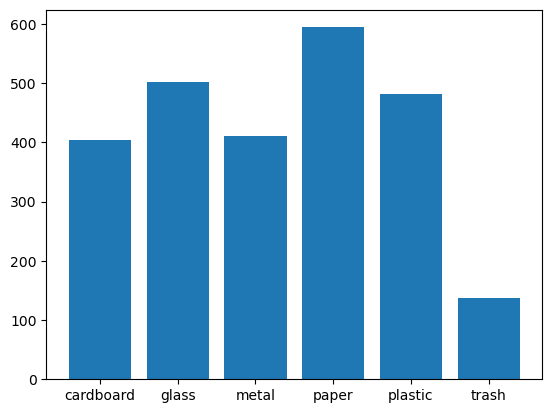

In [9]:
ax = plt.bar(list(map(lambda _class: _class[0], histogram_labels)), list(map(lambda count: count[1], histogram_labels)))

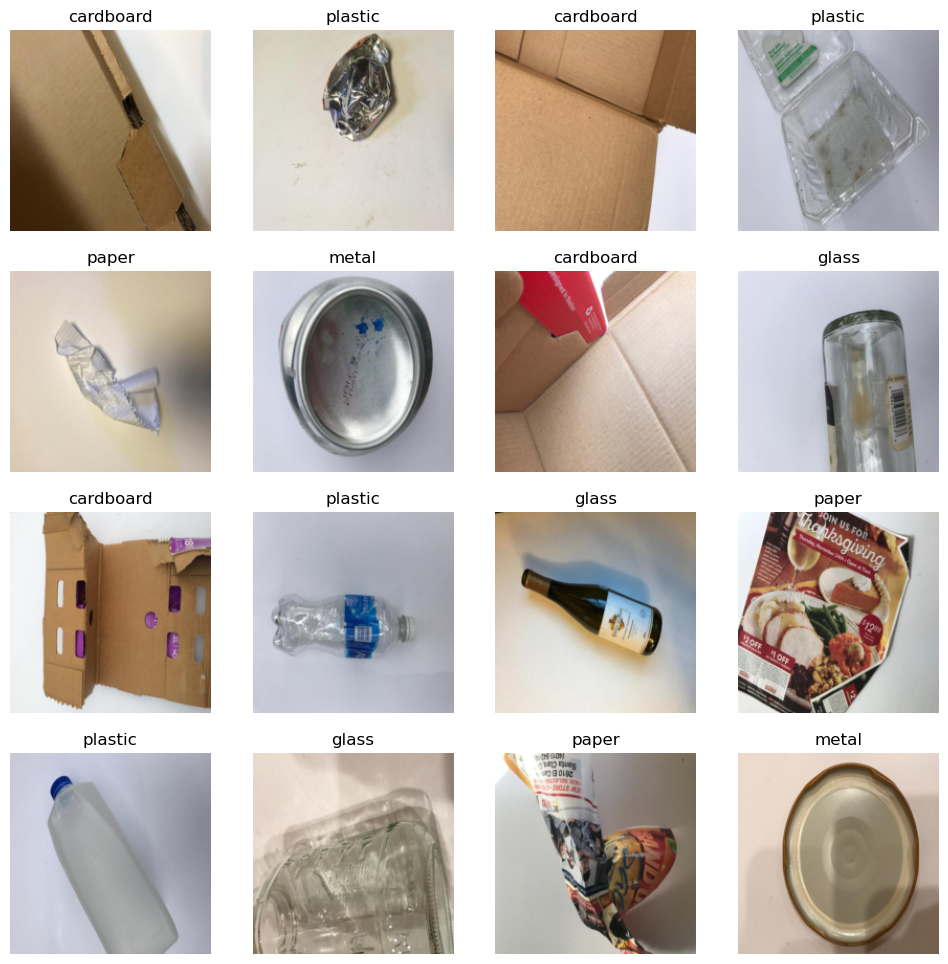

In [10]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=0),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish'), ]
).dataloaders(path, bs=16)

dls.show_batch(max_n=16)

## Data preprocessing

In [11]:
train_datagen = ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.1,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1
)

test_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.1
)

In [12]:
target_size= (224, 224)

train_generator = train_datagen.flow_from_directory(path,
    target_size=target_size,
    class_mode='categorical',
    subset='training'
)

test_generator = test_datagen.flow_from_directory(path,
    target_size=target_size,
    batch_size=251,
    class_mode='categorical',
    subset='validation'
)

Found 2276 images belonging to 6 classes.
Found 251 images belonging to 6 classes.


In [13]:
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys()) 

## Custom model

In [14]:
optimizer = Adam(learning_rate=0.0001)

#### Non-regularized model

In [15]:
early_stopping = EarlyStopping(
    monitor='val_loss',  
    min_delta=0.001,     
    patience=10,       
    verbose=1,           
    mode='min',          
    restore_best_weights=True
)

In [16]:
custom_model_nr = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(), 
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(6, activation='softmax')
])

custom_model_nr.compile(optimizer = optimizer,
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

In [17]:
hist = custom_model_nr.fit(train_generator, epochs = 14, validation_data = test_generator, callbacks=[early_stopping], validation_steps=test_generator.samples // test_generator.batch_size)

Epoch 1/14
72/72 [==============================] - 52s 710ms/step - loss: 1.6811 - accuracy: 0.4222 - val_loss: 1.7380 - val_accuracy: 0.3586
Epoch 2/14
72/72 [==============================] - 50s 692ms/step - loss: 1.1972 - accuracy: 0.5510 - val_loss: 1.6880 - val_accuracy: 0.3665
Epoch 3/14
72/72 [==============================] - 48s 665ms/step - loss: 1.0700 - accuracy: 0.6006 - val_loss: 1.6256 - val_accuracy: 0.3267
Epoch 4/14
72/72 [==============================] - 50s 693ms/step - loss: 0.9772 - accuracy: 0.6388 - val_loss: 1.5420 - val_accuracy: 0.4502
Epoch 5/14
72/72 [==============================] - 48s 663ms/step - loss: 0.9197 - accuracy: 0.6538 - val_loss: 1.4207 - val_accuracy: 0.4741
Epoch 6/14
72/72 [==============================] - 50s 695ms/step - loss: 0.8728 - accuracy: 0.6845 - val_loss: 1.2194 - val_accuracy: 0.5896
Epoch 7/14
72/72 [==============================] - 49s 675ms/step - loss: 0.8134 - accuracy: 0.7074 - val_loss: 1.1015 - val_accuracy: 0.6135

### Evaluation

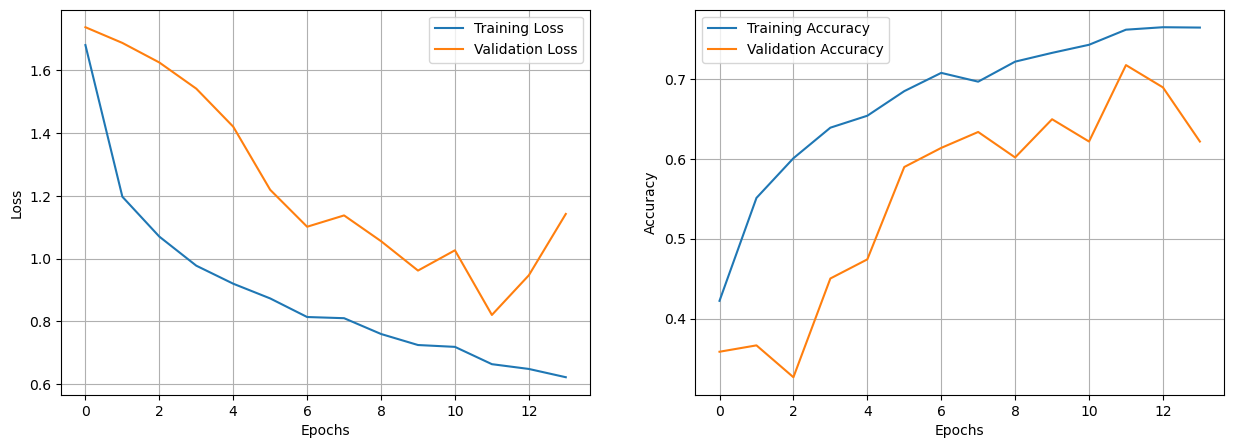

In [18]:
plot_loss_and_acc(hist)

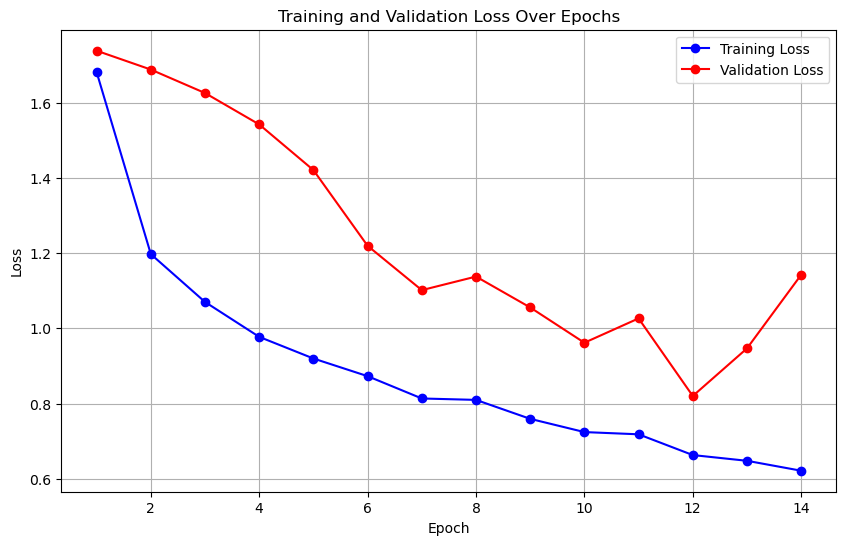

In [19]:
plot_cost(hist.history['loss'], hist.history['val_loss'])

1/1 [==============================] - 1s 1s/step


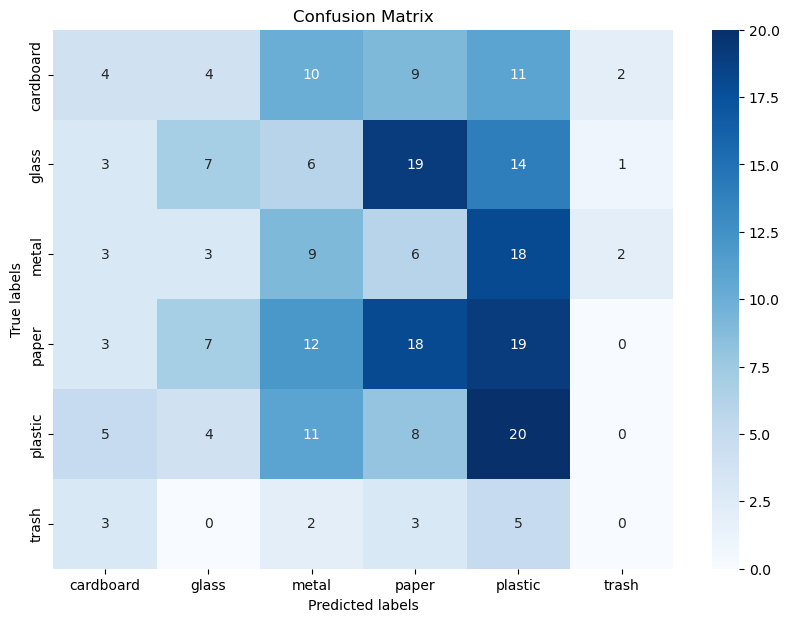

In [20]:
custom_model_predicted_classes = predict_classes(custom_model_nr, test_generator)
metrics_cus = count_metrics(true_classes, custom_model_predicted_classes)

show_confusion_matrix(true_classes, custom_model_predicted_classes, class_labels)

#### Regularized model

In [21]:
custom_model_r = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(), 
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(6, activation='softmax')
])

custom_model_r.compile(optimizer = optimizer,
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

In [22]:
custom_model_r.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 batch_normalization_1 (Batc  (None, 109, 109, 64)     256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                      

In [23]:
hist = custom_model_r.fit(train_generator, epochs = 14, validation_data = test_generator, callbacks=[early_stopping], validation_steps=test_generator.samples // test_generator.batch_size)

Epoch 1/14
72/72 [==============================] - 56s 769ms/step - loss: 2.5798 - accuracy: 0.3941 - val_loss: 1.7795 - val_accuracy: 0.2072
Epoch 2/14
72/72 [==============================] - 58s 797ms/step - loss: 1.2567 - accuracy: 0.5290 - val_loss: 1.7761 - val_accuracy: 0.2749
Epoch 3/14
72/72 [==============================] - 57s 783ms/step - loss: 1.1592 - accuracy: 0.5637 - val_loss: 1.7396 - val_accuracy: 0.2988
Epoch 4/14
72/72 [==============================] - 58s 800ms/step - loss: 1.0811 - accuracy: 0.5848 - val_loss: 1.7098 - val_accuracy: 0.2669
Epoch 5/14
72/72 [==============================] - 57s 792ms/step - loss: 1.0398 - accuracy: 0.6322 - val_loss: 1.5804 - val_accuracy: 0.4940
Epoch 6/14
72/72 [==============================] - 57s 787ms/step - loss: 0.9833 - accuracy: 0.6296 - val_loss: 1.4439 - val_accuracy: 0.5259
Epoch 7/14
72/72 [==============================] - 57s 791ms/step - loss: 0.9641 - accuracy: 0.6415 - val_loss: 1.2712 - val_accuracy: 0.5418

### Evaluation

In [ ]:
plot_loss_and_acc(hist)

In [ ]:
plot_cost(hist.history['loss'], hist.history['val_loss'])

In [ ]:
custom_model_predicted_classes = predict_classes(custom_model_r, test_generator)
metrics_cus = count_metrics(true_classes, custom_model_predicted_classes)

show_confusion_matrix(true_classes, custom_model_predicted_classes, class_labels)

In [ ]:
report = classification_report(true_classes, custom_model_predicted_classes, target_names=class_labels)
print(report)

## ResNet50 

In [ ]:
ResNet50_model = ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
ResNet50_model.trainable = False

custom_ResNet50 = Sequential([
    ResNet50_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dense(6, activation='softmax') 
])

custom_ResNet50.summary()

In [ ]:
custom_ResNet50.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
hist = custom_ResNet50.fit(train_generator, epochs=10, validation_data=test_generator)

### Evaluation

In [ ]:
plot_loss_and_acc(hist)

In [ ]:
plot_cost(hist.history['loss'], hist.history['val_loss'])

In [ ]:
res_model_predicted_classes = predict_classes(custom_ResNet50, test_generator)
metrics_res = count_metrics(true_classes, res_model_predicted_classes)

show_confusion_matrix(true_classes, res_model_predicted_classes, class_labels)

In [ ]:
report = classification_report(true_classes, res_model_predicted_classes, target_names=class_labels)
print(report)

## MobileNetV2

In [ ]:
MobileNetV2_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
MobileNetV2_model.trainable = False

custom_MobileNetV2 = Sequential([
    MobileNetV2_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dense(6, activation='softmax') 
])

custom_MobileNetV2.summary()

In [ ]:
custom_MobileNetV2.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
hist = custom_MobileNetV2.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=test_generator,
    epochs=10
)


### Evaluation

In [ ]:
plot_loss_and_acc(hist)

In [ ]:
plot_cost(hist.history['loss'], hist.history['val_loss'])

In [ ]:
mob_model_predicted_classes = predict_classes(custom_MobileNetV2, test_generator)
metrics_meb = count_metrics(true_classes, mob_model_predicted_classes)

show_confusion_matrix(true_classes, mob_model_predicted_classes, class_labels)

In [ ]:
report = classification_report(true_classes, mob_model_predicted_classes, target_names=class_labels)
print(report)

## Models comparison

In [ ]:
df_metrics = pd.DataFrame({
    'Custom model': metrics_cus,
    'ResNet50': metrics_res,
    'MobileNetV2': metrics_meb,
}, index=['Accuracy', 'Precision', 'Recall', 'F1 Score'])

df_metrics